# Spettro del Rubino

In [1]:
import sys
print(sys.executable)
import scipy
import numpy

c:\Python312\python.exe


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib import rcParams
import modules.utils as utils
from importlib import reload
from functools import partial
from typing import Literal
import ast
reload(utils)

OUT_PATHS = {
    'figs_dir' : './figures',
    'results_dir' : './results',
}
IN_PATHS = {
    'black_body_dir' : './raw_data/Black_Body_Radiation',
    'na_dir' : './raw_data/Na_Spectrum',
    'ruby_dir' : './raw_data/Ruby_Spectrum',
    'laser_dir' : './raw_data/Laser_Spectrum',
}

# default figure settings
FIG_SIZE = np.array([6.4, 4]) # 16:10 aspect ratio
SAVE_FIG = True
FIG_FMT = 'pdf'
TRANSPARENT_PNG=True

# setting up stuff
savefig = partial(utils.save_fig, fig_dir=OUT_PATHS['figs_dir'], fig_fmt=FIG_FMT, fig_size=FIG_SIZE, save=SAVE_FIG, transparent_png=TRANSPARENT_PNG)
utils.check_paths(IN_PATHS, OUT_PATHS)

# style helpers
def fmtax(ax, label : bool | Literal['x', 'y'] = False, loc = 'upper left'):
    if label == True:
        ax.set_xlabel(r'wavelength [nm]')
        ax.set_ylabel(r'intensity [a.u.]')
    elif label == 'x':
        ax.set_xlabel(r'wavelength [nm]')
    elif label == 'y':
        ax.set_ylabel(r'intensity [a.u.]')
    ax.legend(loc=loc, frameon=False)
    ax.tick_params(direction='in', which='both')
    ax.minorticks_on()

,type,id,date,integration time,PT tension,output slit,input slit,lock freq,temp,start,stop,step,samples
0,Rb,001,07112024,300ms,450V,2tac,2tac,307Hz,NaN,6901.060059,7000.0,1.008301,99
1,Rb,002,07112024,300ms,450V,1tac,1tac,307Hz,NaN,6880.602539,7000.0,0.602539,199
2,Rb,003,07112024,300ms,450V,1tac,1tac,307Hz,NaN,7002.104980,7300.0,1.504395,199
3,Rb,004,07112024,300ms,450V,1tac,1tac,307Hz,NaN,7303.045410,7500.0,1.247559,159
4,Rb,005,07112024,300ms,450V,1tac,1tac,307Hz,NaN,6890.741699,7050.0,0.643066,249
5,Rb,001,14112024,300ms,700V,2tac,2tac,307Hz,300K,6890.643066,7050.0,0.641113,249
6,Rb,002,14112024,300ms,700V,2tac,2tac,307Hz,77K,6890.416992,7015.0,0.419434,299
7,Rb,003,14112024,300ms,700V,2tac,2tac,307Hz,77K,7000.602539,7180.0,0.600586,299
8,Rb,004,14112024,300ms,700V,2tac,2tac,307Hz,4p7-5mV,6890.716309,7015.0,0.417480,299
9,Rb,005,14112024,300ms,700V,2tac,2tac,307Hz,5mV,6951.498535,7100.0,0.498535,299


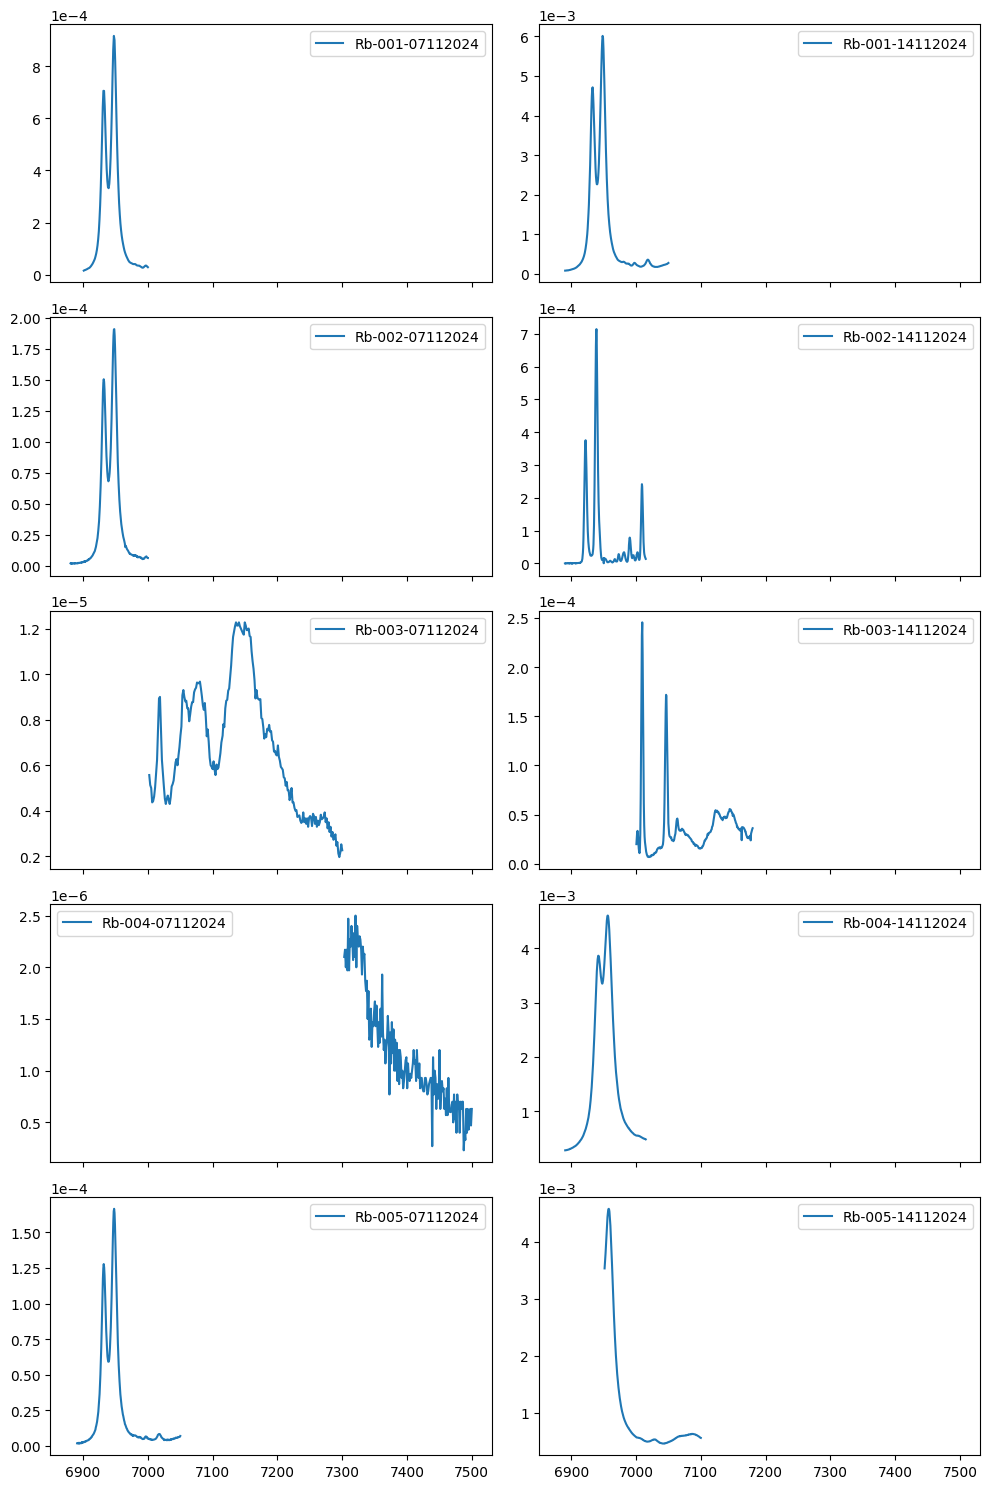

In [3]:
files = utils.getFiles('Raw_Data\\Ruby_Spectrum')
files = [file for file in files if file.name.find('Rb_') != -1]
df = pd.DataFrame([utils.file_to_series(file) for file in files])

# sort it
df.sort_values('id', inplace=True)
df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)

# A quick look at the batch
fig, axs = plt.subplots(5, 2, sharex=True, figsize=(10, 15), layout='tight')
for i, row in df.iterrows():
    meta = ast.literal_eval(row['meta'])
    label = "-".join([meta.get(key) for key in ['type', 'id', 'date',]])
    axs[ i % 5, int(i / 5)].plot(row['wl'], row['mean'], label=label)
    
for ax in axs.flat:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 
    ax.legend()
    
# generate the info table
info = df['meta'].apply(ast.literal_eval).apply(pd.Series)
info = info[['type', 'id', 'date'] + [col for col in info.columns if col not in ['type', 'id', 'date']]]
info['start'] = df['wl'].apply(lambda x: x[0])
info['stop'] = df['wl'].apply(lambda x: x[-1])
info['step'] = df['wl'].apply(lambda x: x[1] - x[0])
info['samples'] = df['wl'].apply(len)

info

,type,id,date,integration time,PT tension,output slit,input slit,lock freq,temp,start,stop,step,samples
0,Rb,001,07112024,300ms,450V,2tac,2tac,307Hz,NaN,6901.060059,7000.0,1.008301,99
1,Rb,002,07112024,300ms,450V,1tac,1tac,307Hz,NaN,6880.602539,7000.0,0.602539,199
2,Rb,003,07112024,300ms,450V,1tac,1tac,307Hz,NaN,7002.104980,7300.0,1.504395,199
3,Rb,004,07112024,300ms,450V,1tac,1tac,307Hz,NaN,7303.045410,7500.0,1.247559,159
4,Rb,005,07112024,300ms,450V,1tac,1tac,307Hz,NaN,6890.741699,7050.0,0.643066,249


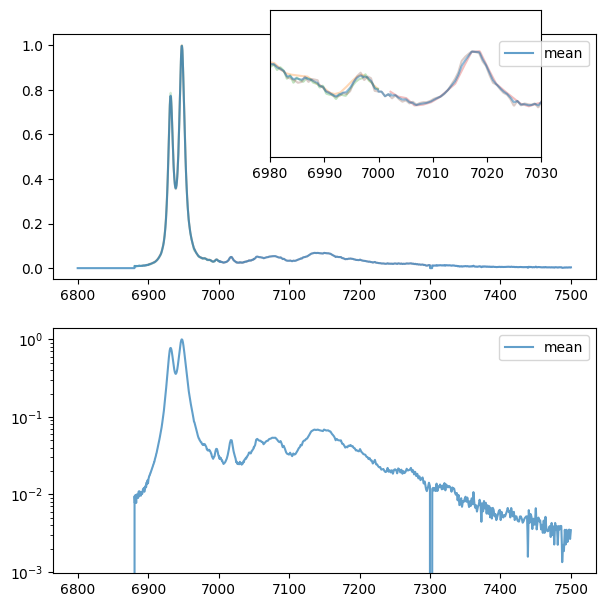

In [4]:
from scipy.interpolate import interp1d

def mean_overlap(comm_wl : np.ndarray, batch : pd.DataFrame):
    ''' 
    This function computes the mean of varius slices of
    batch over an interval
    '''
    
    # this is the result
    mean = np.zeros(len(comm_wl))
    
    # this counts the number of samples 
    # in each wl
    counts = np.zeros(len(comm_wl))
    
    for i, row in batch.iterrows():
        wl = row['int_wl']
        y = row['int_mean']
        min = np.argmax(comm_wl >= wl.min())
        max = np.argmax(comm_wl > wl.max())
        
        # if the max is 0, it means that the wl is larger than the maximum
        if max == 0:
            max = len(comm_wl)

        mean[min:max]  =  mean[min:max] + y
        counts[min:max] = counts[min:max] + 1
    
    mean = np.divide(mean, counts, out=np.zeros_like(mean), where=counts!=0)
    return mean

def myinterp(series, x_new):
    # extract the x and y values
    x = series['wl']
    y = series['mean']
    
    # keep only the values that are within the range
    mask = np.logical_and(x_new > x.min(), x_new < x.max())
    x_new = x_new[mask]
    
    # return both the new x and the interpolated values
    f = interp1d(x, y, kind='linear')
    return x_new, f(x_new)

def interpolate_batch(batch, common_wl):
    ''' 
    If normalization is not given divide by the maximum value
    '''    
    # interpolate the batch
    batch['interp'] = batch.apply(myinterp, x_new = common_wl, axis=1).to_numpy()
    batch['int_wl'] = batch['interp'].apply(lambda x: x[0])
    batch['int_mean'] = batch['interp'].apply(lambda x: x[1])

    common_mean = mean_overlap(common_wl, batch)
    return common_mean

def plot_interp_batch(batch, common_wl, common_mean):
    fig, axs = plt.subplots(2, 1, figsize=(7, 7))
    # inset 
    inset = axs[0].inset_axes([0.4, 0.5, 0.5, 0.6])
    inset.set_xlim(6980, 7030)
    inset.set_ylim(0, .07)
    inset.set(yticks=[])
    
    # plot the mean
    axs[0].plot(common_wl, common_mean, label='mean', alpha = 0.7, zorder = 2)
    inset.plot(common_wl, common_mean, label='mean', alpha = 0.5, zorder = 2)

    # plot the interpolated batch
    batch['interp'].apply(lambda x: axs[0].plot(x[0], x[1], alpha=0.2, zorder = 1))
    batch['interp'].apply(lambda x: inset.plot(x[0], x[1], alpha=0.3, zorder = 1))

    # plot a clean result in log scale
    axs[1].plot(common_wl, common_mean, label='mean', alpha = 0.7, zorder = 2)
    axs[1].set_yscale('log')

    for ax in axs.flat:
        ax.legend()  
    return axs

def normalize(series : pd.Series , ids : list, norm = None):
    if not (series['id'] in ids):
        return series
    
    if norm is None:
        norm = series['mean'].max()
   
    series['mean'] = series['mean'] / norm
    return series

# @ room temperature
mask = df['date'] == '07112024' 
batch_0 = df[mask]
display(info[mask])
  
batch_0 = batch_0.apply(normalize, ids = ['001', '002', '005'] ,  axis=1)
batch_0 = batch_0.apply(normalize, ids = ['003', '004'] ,  axis=1, norm = 0.000179)

common_wl = np.arange(6800, 7500, 0.1)
common_mean = interpolate_batch(batch_0, common_wl)

axs = plot_interp_batch(batch_0, common_wl, common_mean)

,type,id,date,integration time,PT tension,output slit,input slit,lock freq,temp,start,stop,step,samples
5,Rb,001,14112024,300ms,700V,2tac,2tac,307Hz,300K,6890.643066,7050.0,0.641113,249
6,Rb,002,14112024,300ms,700V,2tac,2tac,307Hz,77K,6890.416992,7015.0,0.419434,299
7,Rb,003,14112024,300ms,700V,2tac,2tac,307Hz,77K,7000.602539,7180.0,0.600586,299
8,Rb,004,14112024,300ms,700V,2tac,2tac,307Hz,4p7-5mV,6890.716309,7015.0,0.417480,299
9,Rb,005,14112024,300ms,700V,2tac,2tac,307Hz,5mV,6951.498535,7100.0,0.498535,299


C:\Users\alber\AppData\Local\Temp\ipykernel_20160\1568856668.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_0['temp'] = info.loc[mask, 'temp'].values
C:\Users\alber\AppData\Local\Temp\ipykernel_20160\1568856668.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_0['temp_groups'] = ['300K', '77K', '77K', '400K', '400K']
C:\Users\alber\AppData\Local\Temp\ipykernel_20160\1568856668.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

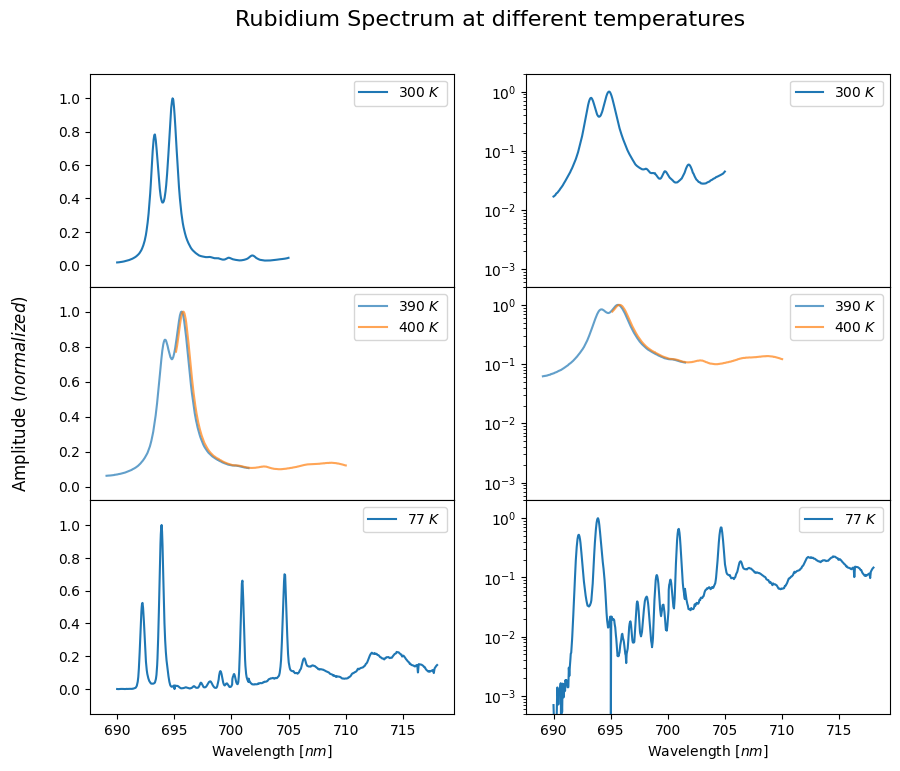

In [5]:
mask = df['date'] == '14112024' 
batch_0 = df[mask]
display(info[mask])

# add the temperature
batch_0['temp'] = info.loc[mask, 'temp'].values

# HACk
batch_0['temp_groups'] = ['300K', '77K', '77K', '400K', '400K']
batch_0['temp'] = ['300K', '77K', '77K', '390K', '400K']
ids = ['001', '002', '003', '004', '005']

common_wl = np.arange(6900, 7200, 0.1)

fig, axs = plt.subplots(3, 2, figsize=(10, 8), sharex=True)
i = 0
for gid, group in batch_0.groupby('temp_groups'):

    # normalize the group
    group = group.apply(normalize, axis=1, ids = ids)

    # interpolate the group    
    if gid == '400K':
        group.apply(lambda x: axs[i, 0].plot(x['wl'] / 10, x['mean'], alpha=0.7, 
                                             label = r'${}\ K$'.format(x['temp'][:-1])), axis=1)
        group.apply(lambda x: axs[i, 1].plot(x['wl'] / 10, x['mean'], alpha=0.7, 
                                             label = r'${}\ K$'.format(x['temp'][:-1])), axis=1)
    else:
        label = r'${}\ K$'.format(gid[:-1])
        common_mean = interpolate_batch(group, common_wl)
        # plot
        mask = common_mean > 0
        axs[i, 0].plot(common_wl[mask] / 10, common_mean[mask], label=label)
        axs[i, 1].plot(common_wl[mask] / 10, common_mean[mask], label=label)
        
    axs[i, 0].margins(y=0.15)
    axs[i, 1].set_ylim(5e-4, 2)
    axs[i, 1].set_yticks([1e-3, 1e-2, 1e-1, 1])
    axs[i, 1].margins(y=0.15)
    axs[i, 1].set_yscale('log')
    i = i + 1

fig.subplots_adjust(hspace=0, left=0.1, right=0.9, top=0.9, bottom=0.1)
fig.supylabel('Amplitude $(normalized)$')
fig.suptitle('Rubidium Spectrum at different temperatures', fontsize=16)

# common_mean = interpolate_batch(batch_0, common_wl)
for ax in axs.flat:
    ax.set_xlabel('Wavelength $[nm]$')
    ax.legend()

# Fit dei picchi del Rubino con Voight - updated

## Importo dati

In [6]:
data_hot = df[(df["date"] == "14112024") & (df["id"] == "004")]
wl_hot = data_hot["wl"].values[0]
#convert to nm
wl_hot = wl_hot/10
sign_hot = data_hot["mean"].values[0]

data_cold = df[(df["date"] == "14112024") & (df["id"] == "002")]
wl_cold = data_cold["wl"].values[0]
#convert to nm
wl_cold = wl_cold/10
sign_cold = data_cold["mean"].values[0]

data_RT = df[(df["date"] == "14112024") & (df["id"] == "001")]
#convert to nm
wl_RT = data_RT["wl"].values[0]
wl_RT = wl_RT/10
sign_RT = data_RT["mean"].values[0]

## Setting figures

In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib import rcParams
import modules.utils as utils
from importlib import reload
from functools import partial
from typing import Literal
reload(utils)

OUT_PATHS = {
    'figs_dir' : './figures',
    'results_dir' : './results',
}
IN_PATHS = {
    'black_body_dir' : './raw_data/Black_Body_Radiation',
    'na_dir' : './raw_data/Na_Spectrum',
    'ruby_dir' : './raw_data/Ruby_Spectrum',
    'laser_dir' : './raw_data/Laser_Spectrum',
}

# default figure settings
FIG_SIZE = np.array([6.4, 4]) # 16:10 aspect ratio
SAVE_FIG = True
FIG_FMT = 'pdf'
TRANSPARENT_PNG=True

# setting up stuff
#savefig = partial(utils.save_fig, fig_dir=OUT_PATHS['figs_dir'], fig_fmt=FIG_FMT, fig_size=FIG_SIZE, save=SAVE_FIG, transparent_png=TRANSPARENT_PNG)
#utils.check_paths(IN_PATHS, OUT_PATHS)

# style helpers
def fmtax(ax, label : bool | Literal['x', 'y'] = False, loc = 'upper left'):
    if label == True:
        ax.set_xlabel(r'wavelength [nm]')
        ax.set_ylabel(r'intensity [a.u.]')
    elif label == 'x':
        ax.set_xlabel(r'wavelength [nm]')
    elif label == 'y':
        ax.set_ylabel(r'intensity [a.u.]')
    ax.legend(loc=loc, frameon=False)
    ax.tick_params(direction='in', which='both')
    ax.minorticks_on()

In [8]:
from lmfit import Minimizer, create_params, report_fit
from lmfit.lineshapes import gaussian, lorentzian, voigt, linear
from lmfit.models import VoigtModel, LinearModel, ConstantModel

def fit_Rub(sample, model, params):
    # get the relevant data
    wl = sample['wl'].values[0]/10
    mean = sample['mean'].values[0]
    std = sample['std'].values[0]
    
    weights = np.maximum(np.abs(std), 1e-6 / np.sqrt(3))
    weights = 1 / weights

    # fit the data
    result = model.fit(mean, params, weights=weights,  x=wl)
    return result

def plot_Rub(sample, result, fig_name):
    
    # style options
    kw = {'marker':'.',
        'capsize':2,
        'linestyle':'none',
        'alpha':.7}
    
    wl = sample['wl'].values[0]/10
    
    with plt.style.context(['seaborn-v0_8-colorblind', 'seaborn-v0_8-paper']):  
        fig = result.plot(data_kws=kw, title=' ')
        fig.tight_layout()
        fig.subplots_adjust(hspace=.08)

        components = result.eval_components(params=result.params, x=wl)

        # major ticks inside
        axs = fig.get_axes()
        axs[0].tick_params(direction='in', which='both')
        # plot the peaks
        ax_peak = fig.add_subplot(313, sharex=axs[0], sharey=axs[1])
        ax_peak.set_ylabel(r'peaks [a.u.]')

        for key in components.keys():
            if key == 'bkg_':
                continue
            label = result.params[f'{key}center'].value
            label = f'{label:.2f} nm'
            ax_peak.plot(wl, components[key], label=label)
            ax_peak.fill_between(wl, components[key], 0, alpha = 0.2)  

        # move it a little down
        pos = ax_peak.get_position()
        delta = pos.height + 0.06
        ax_peak.set_position([pos.x0, pos.y0 - delta, pos.width, pos.height])
        ax_peak.tick_params(direction='in', which='both')
        ax_peak.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax_peak.legend(loc='upper right', frameon=False)
        ax = axs[1]
        ax.text(0.05, 0.95, 'T = 395 [K]', transform=ax.transAxes, fontsize=10, verticalalignment='top', 
            horizontalalignment='left', color='black', weight='bold')
        # format the axes
        fmtax(axs[1], loc='upper right', label='y')
        axs[1].set_xlabel(None)
        ax_peak.set_xlabel(r'wavelength [nm]')
        
        # show and save
        savefig(fig, fig_name = fig_name) 
        plt.show()  


# FIT HOT

[[Model]]
    ((Model(voigt, prefix='one_') + Model(voigt, prefix='two_')) + Model(linear, prefix='bkg_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 129
    # data points      = 299
    # variables        = 10
    chi-square         = 25358.1775
    reduced chi-square = 87.7445589
    Akaike info crit   = 1347.68348
    Bayesian info crit = 1384.68791
    R-squared          = 0.99984098
[[Variables]]
    one_amplitude:  0.00462527 +/- 4.5327e-05 (0.98%) (init = 0.003)
    one_center:     694.083016 +/- 0.00345878 (0.00%) (init = 694.1)
    one_sigma:      0.26442167 +/- 0.00875916 (3.31%) (init = 0.1)
    two_amplitude:  0.01098416 +/- 4.9435e-05 (0.45%) (init = 0.0045)
    two_center:     695.682682 +/- 0.00346600 (0.00%) (init = 695.9)
    two_sigma:      3.6635e-07 +/- 114.307432 (31201770009.93%) (init = 0.1)
    bkg_slope:      1.9386e-05 +/- 1.8853e-07 (0.97%) (init = 6.132099e-08)
    bkg_intercept: -0.01318506 +/- 1.3106e-04 (0.99%) (init = -3

C:\Users\alber\AppData\Roaming\Python\Python312\site-packages\lmfit\model.py:2203: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_array, reduce_complex(self.data),
C:\Users\alber\AppData\Roaming\Python\Python312\site-packages\lmfit\model.py:2324: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_array, residuals,


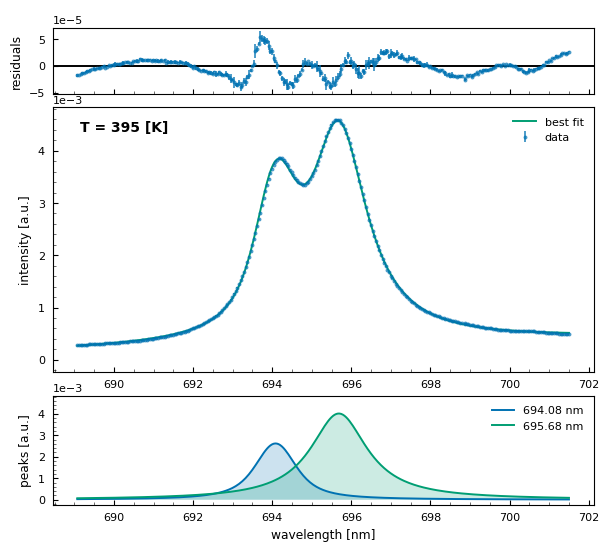

In [9]:
sample = data_hot


# create the model and init the parameters
model = VoigtModel(prefix='one_') + VoigtModel(prefix='two_') + LinearModel(prefix='bkg_')
params = model.make_params()

params['one_center'].set(694.1, min=693, max=695)
params['one_sigma'].set(0.1)
params['one_gamma'].set(0.01, vary=True)
params['one_amplitude'].set(3e-3, min=1e-5)

params['two_center'].set(695.9, min=695, max=697)
params['two_sigma'].set(0.1)
params['two_gamma'].set(0.01, vary=True)
params['two_amplitude'].set(4.5e-3, min=1e-5)

params['bkg_slope'].set(6.132099e-08, vary=True)
params['bkg_intercept'].set(-3.62328e-05, vary=True)

        
result = fit_Rub(sample, model, params)
print(result.fit_report())
plot_Rub(sample,result, 'Rub_14112024_004')  
# exp 0.539  vs theo 0.597 diff 0.058
# exp 589.448 theo 588.995 diff 0.453

# FIT RT

In [10]:
from lmfit import Minimizer, create_params, report_fit
from lmfit.lineshapes import gaussian, lorentzian, voigt, linear
from lmfit.models import VoigtModel, GaussianModel, LinearModel, ConstantModel

def fit_Rub_RT(sample, model, params):
    # get the relevant data
    wl_tot = sample['wl'].values[0]/10
    noise_edgs = {'above' : 701}
    noise_mask = (wl_tot < noise_edgs['above'])
    wl = wl_tot[noise_mask]
    mean_tot = sample['mean'].values[0]
    mean = mean_tot[noise_mask]
    std_tot = sample['std'].values[0]
    std= std_tot[noise_mask]
    
    weights = np.maximum(np.abs(std), 1e-6 / np.sqrt(3))
    weights = 1 / weights

    # fit the data
    result = model.fit(mean, params, weights=weights,  x=wl)
    return result

def plot_Rub_RT(sample, result, fig_name):
    
    # style options
    kw = {'marker':'.',
        'capsize':2,
        'linestyle':'none',
        'alpha':.7}
    
    wl_tot = sample['wl'].values[0]/10
    noise_edgs = {'above' : 701}
    noise_mask = (wl_tot < noise_edgs['above'])
    wl = wl_tot[noise_mask]
    
    with plt.style.context(['seaborn-v0_8-colorblind', 'seaborn-v0_8-paper']):  
        fig = result.plot(data_kws=kw, title=' ')
        fig.tight_layout()
        fig.subplots_adjust(hspace=.08)

        components = result.eval_components(params=result.params, x=wl)

        # major ticks inside
        axs = fig.get_axes()
        axs[0].tick_params(direction='in', which='both')
        # plot the peaks
        ax_peak = fig.add_subplot(313, sharex=axs[0], sharey=axs[1])
        ax_peak.set_ylabel(r'peaks [a.u.]')

        for key in components.keys():
            if key == 'bkg_':
                continue
            label = result.params[f'{key}center'].value
            label = f'{label:.2f} nm'
            ax_peak.plot(wl, components[key], label=label)
            ax_peak.fill_between(wl, components[key], 0, alpha = 0.2)  

        # move it a little down
        pos = ax_peak.get_position()
        delta = pos.height + 0.06
        ax_peak.set_position([pos.x0, pos.y0 - delta, pos.width, pos.height])
        ax_peak.tick_params(direction='in', which='both')
        ax_peak.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax_peak.legend(loc='upper right', frameon=False)
        ax = axs[1]
        ax.text(0.05, 0.95, 'T = 293 [K]', transform=ax.transAxes, fontsize=10, verticalalignment='top', 
            horizontalalignment='left', color='black', weight='bold')
        
        # format the axes
        fmtax(axs[1], loc='upper right', label='y')
        axs[1].set_xlabel(None)
        ax_peak.set_xlabel(r'wavelength [nm]')
        
        # show and save
        savefig(fig, fig_name = fig_name) 
        plt.show()  


[[Model]]
    ((Model(voigt, prefix='one_') + Model(voigt, prefix='two_')) + Model(linear, prefix='bkg_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 195
    # data points      = 186
    # variables        = 10
    chi-square         = 54799.8213
    reduced chi-square = 311.362621
    Akaike info crit   = 1077.53937
    Bayesian info crit = 1109.79684
    R-squared          = 0.99960619
[[Variables]]
    one_amplitude:  0.00473711 +/- 7.1893e-05 (1.52%) (init = 0.003)
    one_center:     693.265332 +/- 0.00708487 (0.00%) (init = 693.3)
    one_sigma:      0.21804378 +/- 0.01283402 (5.89%) (init = 0.1)
    two_amplitude:  0.00882514 +/- 9.6724e-05 (1.10%) (init = 0.0065)
    two_center:     694.867164 +/- 0.00771625 (0.00%) (init = 695.1)
    two_sigma:      0.09684469 +/- 0.04136131 (42.71%) (init = 0.1)
    bkg_slope:      1.3887e-05 +/- 4.1066e-07 (2.96%) (init = 6.132099e-08)
    bkg_intercept: -0.00956861 +/- 2.8608e-04 (2.99%) (init = -3.62328e-0

C:\Users\alber\AppData\Roaming\Python\Python312\site-packages\lmfit\model.py:2203: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_array, reduce_complex(self.data),
C:\Users\alber\AppData\Roaming\Python\Python312\site-packages\lmfit\model.py:2324: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_array, residuals,


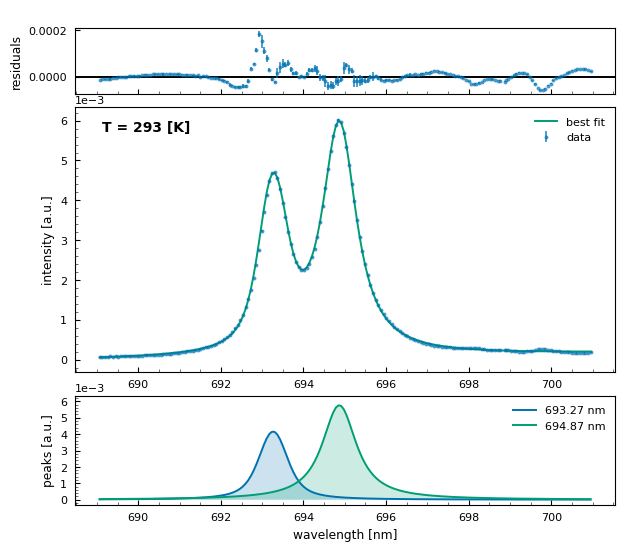

In [11]:
# get the relevant data
sample = data_RT

# create the model and init the parameters
#model = VoigtModel(prefix='one_') + VoigtModel(prefix='two_') + VoigtModel(prefix='three_') + LinearModel(prefix='bkg_')
model = VoigtModel(prefix='one_') + VoigtModel(prefix='two_') + LinearModel(prefix='bkg_')
params = model.make_params()

params['one_center'].set(693.3, min=693, max=695)
params['one_sigma'].set(0.1)
params['one_gamma'].set(0.01, vary=True)
params['one_amplitude'].set(3e-3, min=1e-5)

params['two_center'].set(695.1, min=694, max=697)
params['two_sigma'].set(0.1)
params['two_gamma'].set(0.01, vary=True)
params['two_amplitude'].set(6.5e-3, min=1e-5)

#params['three_center'].set(702, min=701, max=703)
#params['three_sigma'].set(0.1)
#params['three_gamma'].set(0.001, vary=True)
#params['three_amplitude'].set(1e-3, min=1e-5)


params['bkg_slope'].set(6.132099e-08, vary=True)
params['bkg_intercept'].set(-3.62328e-05, vary=True)


result = fit_Rub_RT(sample, model, params)
print(result.fit_report())
plot_Rub_RT(sample,result, 'Rub_14112024_001')  
# exp 0.539  vs theo 0.597 diff 0.058
# exp 589.448 theo 588.995 diff 0.453

# FIT cold

In [12]:
def fit_Rub_cold(sample, model, params):
    # get the relevant data
    wl_tot = sample['wl'].values[0]/10
    noise_edgs = {'above' : 696}
    noise_mask = (wl_tot < noise_edgs['above'])
    wl = wl_tot[noise_mask]
    mean_tot = sample['mean'].values[0]
    mean = mean_tot[noise_mask]
    std_tot = sample['std'].values[0]
    std= std_tot[noise_mask]
    
    weights = np.maximum(np.abs(std), 1e-6 / np.sqrt(3))
    weights = 1 / weights

    # fit the data
    result = model.fit(mean, params, weights=weights,  x=wl)
    return result

def plot_Rub_cold(sample, result, fig_name):
    
    # style options
    kw = {'marker':'.',
        'capsize':2,
        'linestyle':'none',
        'alpha':.7}
    
    wl_tot = sample['wl'].values[0]/10
    noise_edgs = {'above' : 696}
    noise_mask = (wl_tot < noise_edgs['above'])
    wl = wl_tot[noise_mask]
    
    with plt.style.context(['seaborn-v0_8-colorblind', 'seaborn-v0_8-paper']):  
        fig = result.plot(data_kws=kw, title=' ')
        fig.tight_layout()
        fig.subplots_adjust(hspace=.08)

        components = result.eval_components(params=result.params, x=wl)

        # major ticks inside
        axs = fig.get_axes()
        axs[0].tick_params(direction='in', which='both')
        # plot the peaks
        ax_peak = fig.add_subplot(313, sharex=axs[0], sharey=axs[1])
        ax_peak.set_ylabel(r'peaks [a.u.]')

        for key in components.keys():
            if key == 'bkg_':
                continue
            label = result.params[f'{key}center'].value
            label = f'{label:.2f} nm'
            ax_peak.plot(wl, components[key], label=label)
            ax_peak.fill_between(wl, components[key], 0, alpha = 0.2)  

        # move it a little down
        pos = ax_peak.get_position()
        delta = pos.height + 0.06
        ax_peak.set_position([pos.x0, pos.y0 - delta, pos.width, pos.height])
        ax_peak.tick_params(direction='in', which='both')
        ax_peak.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax_peak.legend(loc='upper right', frameon=False)
        
        # format the axes
        fmtax(axs[1], loc='upper right', label='y')
        axs[1].set_xlabel(None)
        ax_peak.set_xlabel(r'wavelenghts [nm]')
        
        ax = axs[1]
        ax.text(0.05, 0.95, 'T = 77 [K]', transform=ax.transAxes, fontsize=10, verticalalignment='top', 
            horizontalalignment='left', color='black', weight='bold')

        # show and save
        savefig(fig, fig_name = 'Rub_14112024_002') 
        plt.show()  


[[Model]]
    ((Model(voigt, prefix='one_') + Model(voigt, prefix='two_')) + Model(linear, prefix='bkg_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2261
    # data points      = 167
    # variables        = 10
    chi-square         = 14473.1748
    reduced chi-square = 92.1858266
    Akaike info crit   = 765.163751
    Bayesian info crit = 796.343689
    R-squared          = 0.99271500
##  Warning: uncertainties could not be estimated:
    two_amplitude:  at boundary
[[Variables]]
    one_amplitude:  1.9544e-04 (init = 0.0006)
    one_center:     692.225532 (init = 692)
    one_sigma:      0.17422766 (init = 0.1)
    two_amplitude:  4.0000e-04 (init = 0.001)
    two_center:     693.898705 (init = 694)
    two_sigma:      0.14457719 (init = 0.1)
    bkg_slope:      4.0950e-07 (init = 6.132099e-08)
    bkg_intercept: -2.8474e-04 (init = -3.62328e-05)
    one_gamma:      0.04255125 (init = 0.1)
    one_fwhm:       0.45767444 == '1.0692*one_gamma+sqrt(0

C:\Users\alber\AppData\Roaming\Python\Python312\site-packages\lmfit\model.py:2203: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_array, reduce_complex(self.data),
C:\Users\alber\AppData\Roaming\Python\Python312\site-packages\lmfit\model.py:2324: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_array, residuals,


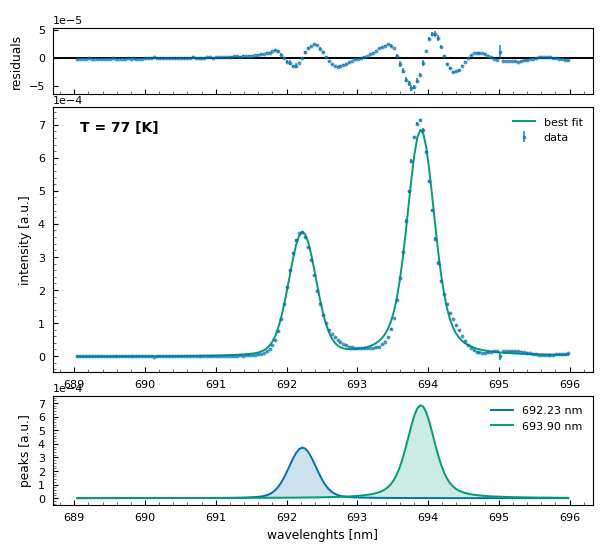

In [13]:
sample=data_cold

# create the model and init the parameters
#model = VoigtModel(prefix='one_') + VoigtModel(prefix='two_') + VoigtModel(prefix='three_') + LinearModel(prefix='bkg_')
#model = VoigtModel(prefix='one_') + VoigtModel(prefix='two_') + VoigtModel(prefix='three_') + LinearModel(prefix='bkg_')
model = VoigtModel(prefix='one_') + VoigtModel(prefix='two_') + LinearModel(prefix='bkg_')
params = model.make_params()

params['one_center'].set(692.0, min=691, max=693)
params['one_sigma'].set(0.1)
params['one_gamma'].set(0.1, vary=True)
params['one_amplitude'].set(6e-4, min=1e-5)

params['two_center'].set(694, min=693, max=694.5)
params['two_sigma'].set(0.1)
params['two_gamma'].set(0.1, vary=True)
params['two_amplitude'].set(1e-3, min=4e-4)

#params['three_center'].set(697.3, min=697, max=697.7)
#params['three_sigma'].set(0.05)
#params['three_gamma'].set(0.05, vary=True)
#params['three_amplitude'].set(0.3e-4, min=0.15e-4)


params['bkg_slope'].set(6.132099e-08, vary=True)
params['bkg_intercept'].set(-3.62328e-05, vary=True)

        
result = fit_Rub_cold(sample, model, params)
print(result.fit_report())
plot_Rub_cold(sample,result, 'Rub_14112024_001')

### plot laser rosso, ma check quello verde

In [14]:
files = utils.getFiles('Raw_Data/Laser_Spectrum')
files = [file for file in files if file.name.find('LSR_') != -1]
df = pd.DataFrame([utils.file_to_series(file) for file in files])

# sort it
df.sort_values('id', inplace=True)
df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)
    
# generate the info table
info = df['meta'].apply(ast.literal_eval).apply(pd.Series)
info = info[['type', 'id', 'date'] + [col for col in info.columns if col not in ['type', 'id', 'date']]]
info['start'] = df['wl'].apply(lambda x: x[0])
info['stop'] = df['wl'].apply(lambda x: x[-1])
info['step'] = df['wl'].apply(lambda x: x[1] - x[0])
info['samples'] = df['wl'].apply(len)

info

c:\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Python312\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of fr

,type,id,date,integration time,PT tension,output slit,input slit,lock freq,start,stop,step,samples
0,LSR,001,07112024,300ms,500V,2tac,2tac,307Hz,6327.178223,6340.000000,0.079590,164
1,LSR,002,07112024,300ms,500V,2tac,1tac,307Hz,6327.278809,6340.100586,0.079102,164
2,LSR,003,07112024,300ms,500V,2tac,1tac,307Hz,6327.479492,6340.399902,0.079590,164
3,LSR,004,07112024,1000ms,500V,2tac,1tac,307Hz,1.000000,49.000000,1.000000,49
4,LSR,005,07112024,1000ms,500V,2tac,1tac,307Hz,1.000000,49.000000,1.000000,49
5,LSR,006,07112024,300ms,500V,2tac,1tac,307Hz,1.000000,49.000000,1.000000,49
6,LSR,007,07112024,100ms,500V,2tac,1tac,307Hz,1.000000,49.000000,1.000000,49
7,LSR,008,07112024,30ms,500V,2tac,1tac,307Hz,1.000000,49.000000,1.000000,49
8,LSR,009,07112024,10ms,500V,2tac,1tac,307Hz,1.000000,49.000000,1.000000,49
9,LSR,010,07112024,3ms,500V,2tac,1tac,307Hz,1.000000,49.000000,1.000000,49


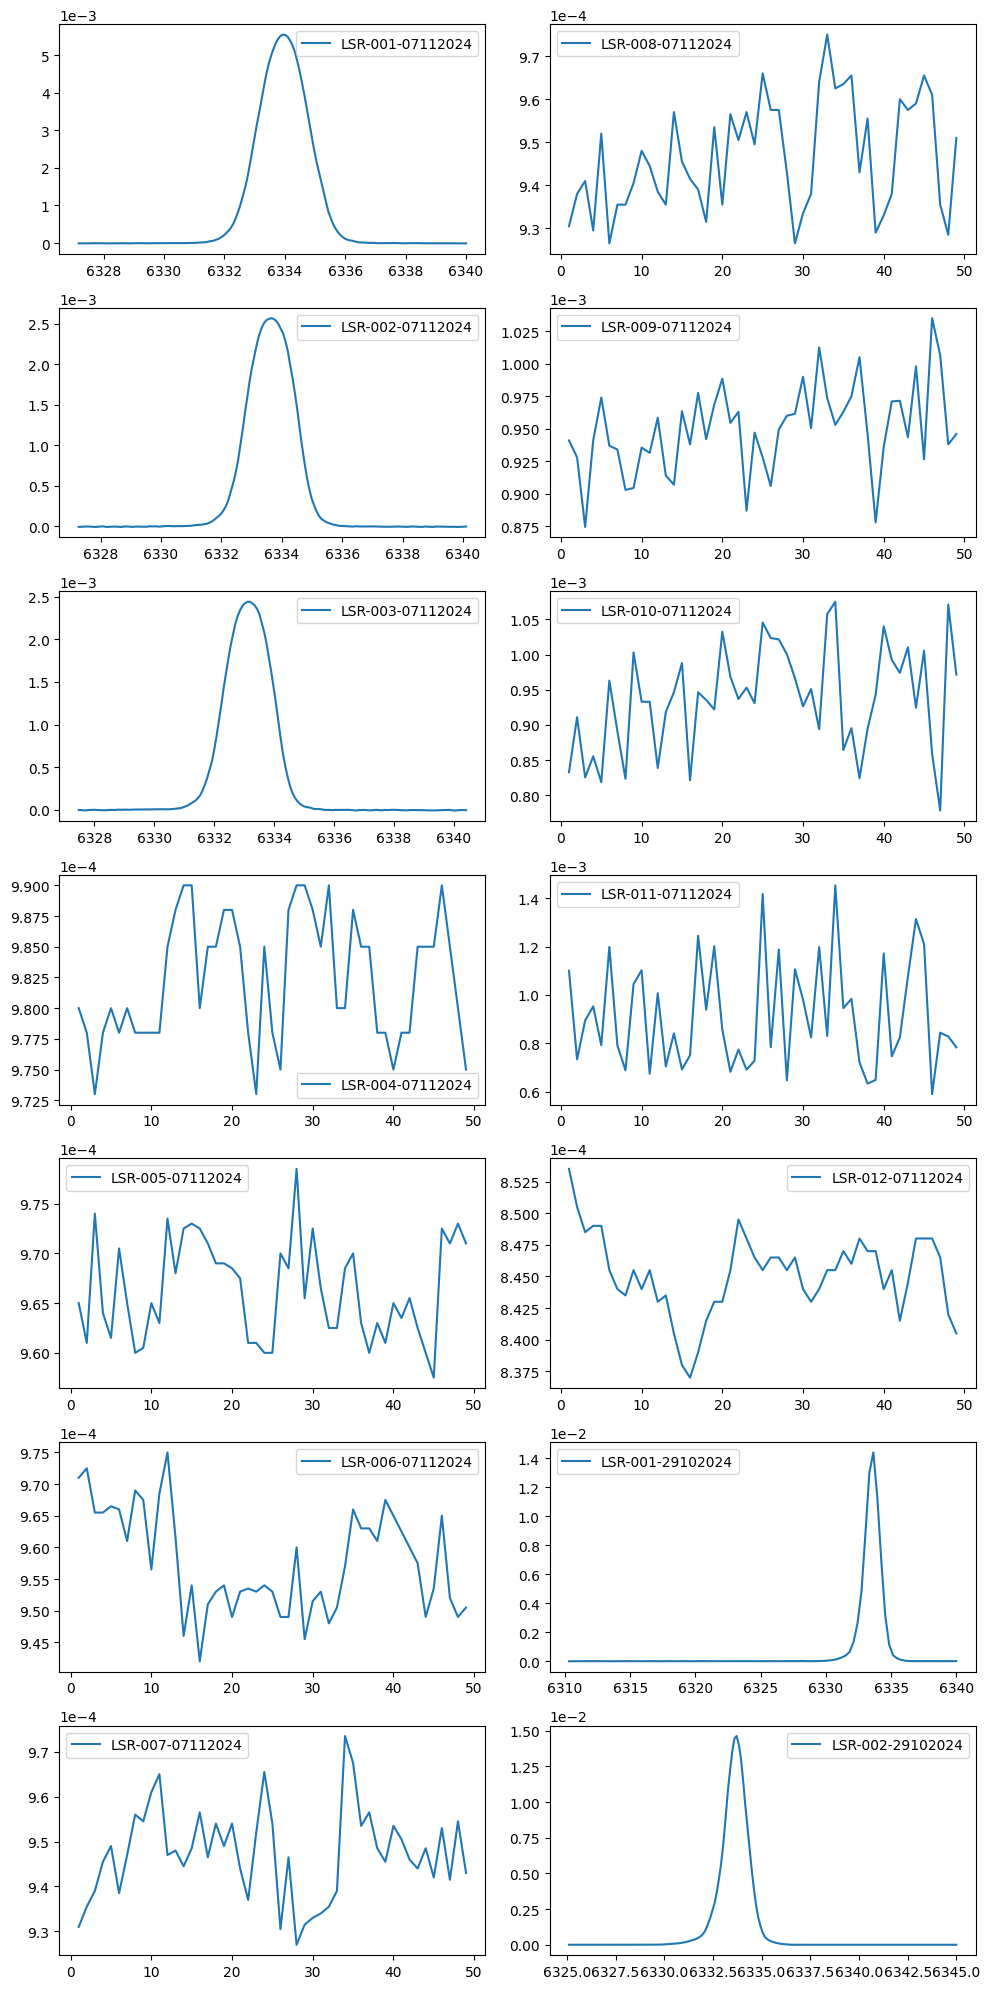

In [15]:
#A quick look at the batch
fig, axs = plt.subplots(7, 2, figsize=(10, 20), layout='tight')
for i, row in df.iterrows():
    meta = ast.literal_eval(row['meta'])
    label = "-".join([meta.get(key) for key in ['type', 'id', 'date',]])
    axs[ i % 7, int(i / 7)].plot(row['wl'], row['mean'], label=label)
    
for ax in axs.flat:
    ax.relim()
    ax.autoscale()
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 
    ax.legend()

In [25]:
data_lsr=df[(df["date"] == "07112024") & (df["id"] == "001")]
wl_lsr = data_lsr["wl"].values[0]
#convert to nm
wl_lsr = wl_lsr/10
sign_lsr = data_lsr["mean"].values[0]

In [26]:
def plot_lsr(sample, result, fig_name):
    
    # style options
    kw = {'marker':'.',
        'capsize':2,
        'linestyle':'none',
        'alpha':.7}
    
    wl_tot = sample['wl'].values[0]/10
    noise_edgs = {'above' : 696}
    noise_mask = (wl_tot < noise_edgs['above'])
    wl = wl_tot[noise_mask]
    
    with plt.style.context(['seaborn-v0_8-colorblind', 'seaborn-v0_8-paper']):  
        fig = result.plot(data_kws=kw, title=' ')
        fig.tight_layout()
        fig.subplots_adjust(hspace=.08)

        components = result.eval_components(params=result.params, x=wl)

        # major ticks inside
        axs = fig.get_axes()
        axs[0].tick_params(direction='in', which='both')
        # plot the peaks
        ax_peak = fig.add_subplot(313, sharex=axs[0], sharey=axs[1])
        ax_peak.set_ylabel(r'peaks [a.u.]')

        for key in components.keys():
            if key == 'bkg_':
                continue
            label = result.params[f'{key}center'].value
            label = f'{label:.2f} nm'
            ax_peak.plot(wl, components[key], label=label)
            ax_peak.fill_between(wl, components[key], 0, alpha = 0.2)  

        # move it a little down
        pos = ax_peak.get_position()
        delta = pos.height + 0.06
        ax_peak.set_position([pos.x0, pos.y0 - delta, pos.width, pos.height])
        ax_peak.tick_params(direction='in', which='both')
        ax_peak.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax_peak.legend(loc='upper right', frameon=False)
        
        # format the axes
        fmtax(axs[1], loc='upper right', label='y')
        axs[1].set_xlabel(None)
        ax_peak.set_xlabel(r'wavelenghts [nm]')
        # scientific notation
        axs[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        
        ax = axs[1]
        
        # show and save
        savefig(fig, fig_name = fig_name) 
        plt.show()  

[[Model]]
    (Model(voigt, prefix='one_') + Model(linear, prefix='bkg_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 83
    # data points      = 164
    # variables        = 6
    chi-square         = 4491.07644
    reduced chi-square = 28.4245344
    Akaike info crit   = 554.836928
    Bayesian info crit = 573.436126
    R-squared          = 0.99705553
[[Variables]]
    one_amplitude:  0.00107270 +/- 2.6742e-06 (0.25%) (init = 0.0006)
    one_center:     633.393903 +/- 3.2560e-04 (0.00%) (init = 633.4)
    one_sigma:      0.07598765 +/- 3.6658e-04 (0.48%) (init = 0.1)
    bkg_slope:     -1.7059e-06 +/- 1.1847e-06 (69.45%) (init = 6.132099e-08)
    bkg_intercept:  0.00107382 +/- 7.5049e-04 (69.89%) (init = -3.62328e-05)
    one_gamma:      0.00117845 +/- 3.0453e-04 (25.84%) (init = 0.1)
    one_fwhm:       0.18019906 +/- 5.9454e-04 (0.33%) == '1.0692*one_gamma+sqrt(0.8664*one_gamma**2+5.545083*one_sigma**2)'
    one_height:     0.00556274 +/- 4.8773e-

C:\Users\alber\AppData\Roaming\Python\Python312\site-packages\lmfit\model.py:2203: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_array, reduce_complex(self.data),
C:\Users\alber\AppData\Roaming\Python\Python312\site-packages\lmfit\model.py:2324: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_array, residuals,


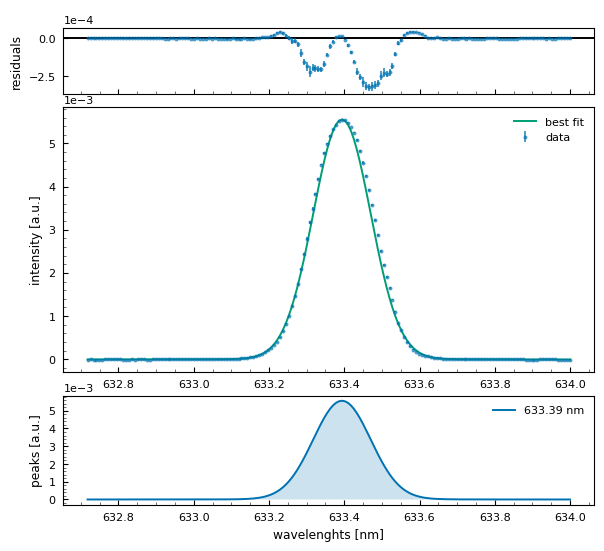

In [27]:
sample=data_lsr

# create the model and init the parameters
#model = VoigtModel(prefix='one_') + VoigtModel(prefix='two_') + VoigtModel(prefix='three_') + LinearModel(prefix='bkg_')
#model = VoigtModel(prefix='one_') + VoigtModel(prefix='two_') + VoigtModel(prefix='three_') + LinearModel(prefix='bkg_')
model = VoigtModel(prefix='one_') + LinearModel(prefix='bkg_')
params = model.make_params()

params['one_center'].set(633.4, min=633, max=634)
params['one_sigma'].set(0.1)
params['one_gamma'].set(0.1, vary=True)
params['one_amplitude'].set(6e-4, min=1e-5)


params['bkg_slope'].set(6.132099e-08, vary=True)
params['bkg_intercept'].set(-3.62328e-05, vary=True)

        
result = fit_Rub(sample, model, params)
print(result.fit_report())
plot_lsr(sample,result, 'Lsr_07112024_001')

In [18]:
data_lsr=df[(df["date"] == "29102024") & (df["id"] == "001")]
wl_lsr = data_lsr["wl"].values[0]
#convert to nm
wl_lsr = wl_lsr/10
sign_lsr = data_lsr["mean"].values[0]

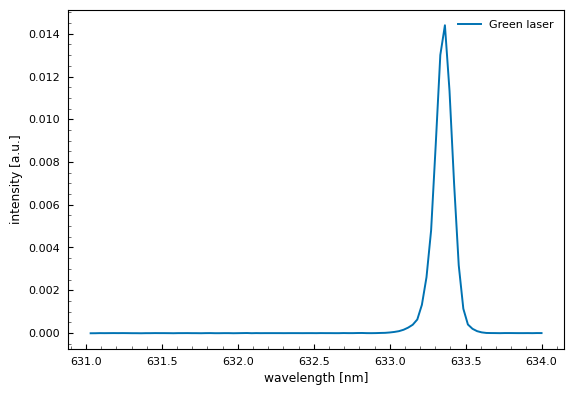

In [19]:
with plt.style.context(['seaborn-v0_8-colorblind', 'seaborn-v0_8-paper']):
    fig, ax = plt.subplots()
    
    ax.plot(wl_lsr, sign_lsr, label='Green laser')
    #ax.plot(wl_lsr, sign_lsr, '--', c='orange',
            #alpha = .6, label='Laser')

    fmtax(ax, label=True, loc='upper right')    
    plt.show()

# Fit dei picchi del Rubino con Voight - parte fatta da Sof

### Pacchetti necessari

In [ ]:
from lmfit import Minimizer, create_params, report_fit, Model
from lmfit.lineshapes import gaussian, lorentzian, voigt
from scipy.stats import linregress
from pprint import pprint
from matplotlib.patches import Rectangle


### Importo dati

In [ ]:
data_hot = df[(df["date"] == "14112024") & (df["id"] == "004")]
wl_hot = data_hot["wl"].values[0]
sign_hot = data_hot["mean"].values[0]

data_cold = df[(df["date"] == "14112024") & (df["id"] == "002")]
wl_cold = data_cold["wl"].values[0]
sign_cold = data_cold["mean"].values[0]

data_RT = df[(df["date"] == "14112024") & (df["id"] == "001")]
wl_RT = data_RT["wl"].values[0]
sign_RT = data_RT["mean"].values[0]


### Plotto dati raw

In [ ]:
fig, axs = plt.subplots(1,3)
axs[0].plot(wl_cold,sign_cold)
axs[1].plot(wl_RT,sign_RT)
axs[2].plot(wl_hot,sign_hot)

### Fit curva cold

In [ ]:
pfit = create_params(amp_1 = 0.0082342, cen_1 = 6922, sig_1 = 5, gamma_1 = 0.05,
                     amp_2 = 0.02, cen_2 = 6939, sig_2 = 5, gamma_2 = 0.9,
                     y0 = 2.03e-6)
# pfit['y0'].set(vary=False)
# pfit['cen_1'].set(value = 8185.46, vary=False)
# pfit['cen_2'].set(value = 8196.06, vary=False)

# fit the noise
noise_edgs = {'below' : 6900,
              'above' : 6960}

noise_mask = (wl_cold < noise_edgs['below']) | (wl_cold > noise_edgs['above'])
noise_mask = (noise_mask) & (wl_cold < 6960) 
print(noise_mask)
res = linregress(wl_cold[noise_mask], sign_cold[noise_mask])
print('mean noise :', np.mean(sign_cold[noise_mask]))
pprint(res)

# remove the noise and fit
clean_sample = sign_cold - np.polyval(res[:2], wl_cold)


mini = Minimizer(residual , pfit, fcn_args=(wl_cold, clean_sample))
out = mini.leastsq()
best_fit = clean_sample + out.residual
report_fit(out.params)

fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(wspace=0.10, right=0.95,
                    hspace=0.45, top=0.95)
axs = axs.flatten()
axs[0].set_title('Noise fit')
#axs[0].set(ylim=(-8e-6, -4e-6))

# noise fit
axs[0].plot(wl_cold, sign_cold, label='signal')
axs[0].axvspan(wl_cold.min(), noise_edgs['below'], color='yellow', alpha=0.3, label='fitting range')
axs[0].axhline(np.mean(sign_cold[noise_mask]), c = 'magenta', label='mean noise')
axs[0].axvspan(noise_edgs['above'], wl_cold.max(), color='yellow', alpha=0.3)
axs[0].plot(wl_cold, np.polyval(res[:2], wl_cold), label = 'linear regression')

# clean sample
axs[1].set_title('Best fit', y=.85)
axs[1].plot(wl_cold, clean_sample, label='clean sample')
axs[1].plot(wl_cold, best_fit, label='best fit')
ax_resid = axs[1].inset_axes([0, 1.1, 1, 0.25], sharex=ax)

# resid
ax_resid.set_title('Resid')
ax_resid.plot(wl_cold, out.residual, label='resid')
ax_resid.axhline(0, c='orange', ls='--')
ax_resid.set_xticks([])

for ax in axs:
    ax.legend()
    ax.set(xlabel=r'wave length $[\AA]$')
    
fig.tight_layout()

### Fit curva RT

In [ ]:
pfit = create_params(amp_1 = 0.0082342, cen_1 = 6925, sig_1 = 3, gamma_1 = 0.005,
                     amp_2 = 0.02, cen_2 = 6955, sig_2 = 7, gamma_2 = 0.03,
                     y0 = 2.03e-6)
# pfit['y0'].set(vary=False)
# pfit['cen_1'].set(value = 8185.46, vary=False)
# pfit['cen_2'].set(value = 8196.06, vary=False)

# fit the noise
noise_edgs = {'below' : 6910,
              'above' : 6975}

noise_mask = (wl_RT < noise_edgs['below']) | (wl_RT > noise_edgs['above'])
res = linregress(wl_RT[noise_mask], sign_RT[noise_mask])
print('mean noise :', np.mean(sign_RT[noise_mask]))
pprint(res)

# remove the noise and fit
clean_sample = sign_RT - np.polyval(res[:2], wl_RT)

mini = Minimizer(residual , pfit, fcn_args=(wl_RT, clean_sample))
out = mini.leastsq()
best_fit = clean_sample + out.residual
report_fit(out.params)

fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(wspace=0.10, right=0.95,
                    hspace=0.45, top=0.95)
axs = axs.flatten()
axs[0].set_title('Noise fit')
#axs[0].set(ylim=(-8e-6, -4e-6))

# noise fit
axs[0].plot(wl_RT, sign_RT, label='signal')
axs[0].axvspan(wl_RT.min(), noise_edgs['below'], color='yellow', alpha=0.3, label='fitting range')
axs[0].axhline(np.mean(sign_RT[noise_mask]), c = 'magenta', label='mean noise')
axs[0].axvspan(noise_edgs['above'], wl_RT.max(), color='yellow', alpha=0.3)
axs[0].plot(wl_RT, np.polyval(res[:2], wl_RT), label = 'linear regression')

# clean sample
axs[1].set_title('Best fit', y=.85)
axs[1].plot(wl_RT, clean_sample, label='clean sample')
axs[1].plot(wl_RT, best_fit, label='best fit')
ax_resid = axs[1].inset_axes([0, 1.1, 1, 0.25], sharex=ax)

# resid
ax_resid.set_title('Resid')
ax_resid.plot(wl_RT, out.residual, label='resid')
ax_resid.axhline(0, c='orange', ls='--')
ax_resid.set_xticks([])

for ax in axs:
    ax.legend()
    ax.set(xlabel=r'wave length $[\AA]$')
    
fig.tight_layout()

### Fit curva hot

### Fit alternativo, curva RT

In [ ]:
from scipy.special import wofz
# IGOR VOIGT FUNCTION WRAPPING
# from CHATGPT but checked for correctness
def voigt_func(x, shape_factor):
    """
    Computes the Voigt function as the real part of the Faddeeva function.
    :param x: Input wave (numpy array)
    :param shape_factor: Determines the Gaussian-Lorentzian mix.
    :return: Voigt peak values.
    """
    return np.real(wofz(x + 1j * shape_factor))

def mpfx_voigt_peak(x,x0, width, height,shape):
    """
    Computes a Voigt peak function and fills yw with computed values.
    :param cw: Coefficient wave (array-like of length 4)
               cw[0]: Peak location
               cw[1]: Width-affecting factor
               cw[2]: Amplitude factor
               cw[3]: Shape factor (0 = Gaussian, Inf = Lorentzian, sqrt(ln(2)) = 50/50)
    :param xw: X values where the function is evaluated
    :return: 0 if successful, NaN if input is invalid
    """
    return height * voigt_func(width * (x - x0), shape)


def residual(pars, x, data):
    x01 = pars['x01']
    width1 = pars['width1']
    height1 = pars['height1']
    shape1 = pars['shape1']
    x02 = pars['x02']
    width2 = pars['width2']
    height2 = pars['height2']
    shape2 = pars['shape2']
    vmodel =  mpfx_voigt_peak(x,x01, width1, height1,shape1) + mpfx_voigt_peak(x,x02, width2, height2,shape2)
    return vmodel - data
    
# Parametri iniziali per il fit
pfit = create_params(x01=6932, width1=0.4, height1=0.01,shape1=1.23,
                     x02= 6948.7, width2=0.73, height2=0.036,shape2=3.34)
# fit the noise
noise_edgs = {'below' : 6905,
              'above' : 6980}

noise_mask = (wl_RT < noise_edgs['below']) | (wl_RT> noise_edgs['above'])
noise_mask=(noise_mask) & (wl_RT < 7000)
res = linregress(wl_RT[noise_mask], sign_RT[noise_mask])
print('mean noise :', np.mean(sign_RT[noise_mask]))
pprint(res)

# remove the noise and fit
clean_sample = sign_RT - np.polyval(res[:2], wl_RT)

fitting_mask = (wl_RT < 6980)

mini = Minimizer(residual , pfit, fcn_args=(wl_RT[fitting_mask], clean_sample[fitting_mask]))
out = mini.leastsq()
best_fit = clean_sample[fitting_mask] + out.residual
report_fit(out.params)

fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(wspace=0.10, right=0.95,
                    hspace=0.45, top=0.95)
axs = axs.flatten()

axs[0].set_title('Noise fit')


# noise fit
axs[0].plot(wl_RT, sign_RT, label='signal')
axs[0].axvspan(wl_RT.min(), noise_edgs['below'], color='yellow', alpha=0.3, label='fitting range')
axs[0].axhline(np.mean(sign_RT[noise_mask]), c = 'magenta', label='mean noise')
axs[0].axvspan(noise_edgs['above'], wl_RT.max(), color='yellow', alpha=0.3)
axs[0].plot(wl_RT, np.polyval(res[:2], wl_RT), label = 'linear regression')

# clean sample
axs[1].set_title('Best fit', y=.85)
axs[1].plot(wl_RT, clean_sample, label='clean sample')
axs[1].plot(wl_RT[fitting_mask], best_fit, label='best fit')
ax_resid = axs[1].inset_axes([0, 1.1, 1, 0.25], sharex=ax)

# resid
ax_resid.set_title('Resid')
ax_resid.plot(wl_RT[fitting_mask], out.residual, label='resid')
ax_resid.axhline(0, c='orange', ls='--')
ax_resid.set_xticks([])

for ax in axs:
    ax.legend()
    ax.set(xlabel=r'wave length $[\AA]$')
    
fig.tight_layout()

# TEST

In [ ]:
import numpy as np
import pandas as pd
import scipy.special as sp
import scipy.optimize as opt
import matplotlib.pyplot as plt

def voigt_function(x, y0, Area, WG, x0, Shape):
    sqrt_ln2 = np.sqrt(np.log(2))
    prefactor = (2 * Area / WG) * np.sqrt(np.log(2) / np.pi)
    arg1 = (2 * sqrt_ln2 / WG) * (x - x0)
    arg2 = Shape * 2 * sqrt_ln2
    return y0 + prefactor * sp.wofz(arg1 + 1j * arg2).real

def double_voigt(x, y0, Area1, WG1, x01, Shape1, Area2, WG2, x02, Shape2):
    res = voigt_function(x, y0, Area1, WG1, x01, Shape1) + voigt_function(x, y0, Area2, WG2, x02, Shape2)
    return res

fig, ax = plt.subplots()
ax.plot(wl_hot,double_voigt(wl_hot, ))

# Fit dei dati con la funzione double_voigt
def fit_double_voigt(x_data, y_data):
    model = double_voigt
    
    # Parametri iniziali per il fit
    pfit = create_params(y0 = 2.3e-6, area1 = 0.0082342, WG1= 3, x01 = 6941, shape1 = 3, area2 = 0.005,
                     WG2 = 0.02, x02 = 6957, shape2 = 7)

    # Esegui il fit
    result = model.fit(y_data, params, x=x_data)
    return result


fig, ax = plt.subplots()
ax.plot(wl_hot,fit_double_voigt(wl_hot,sign_hot))